# Projet ELTDM : Optimisation de l'inférence d'un classifieur RandomForest  en utilisant une représentation matricielle


## Introduction
En Machine Learning, les tâches d'apprentissage et d'inférence, pourtant très liées, répondent à des cahiers des charges très différents.

La tâche d'apprentissage requiert de pouvoir ingérer de larges volumes de données, d'être paramétrable, de posséder des représentations internes lisibles, interprétables et facilement déboguables, et surtout de tout mettre en oeuvre pour arriver à la meilleure performance prédictive possible. Si le temps d'exécution peut être important pour assurer un haut débit de données ingérées, la latence d'une prédiction est rarement une considération importante pour la phase d'apprentissage.

La tâche d'inférence, elle, a souvent pour priorités non seulement le débit, mais aussi la latence des prédictions et les empreintes mémoire et disque. L'interprétabilité des représentations internes est moins importante car la phase d'expérimentation est finie.

La bibliothèque python `scikit-learn` propose des implémentations de nombreux algorithmes courants de Machine Learning, auxquelles on peut accéder par une API très simple (un modèle = un objet ayant une méthode `.fit` et une méthode `.predict`) et dont le code est souvent plutôt simple et direct. Un exemple d'algorithme très populaire implémenté dans ce package est l'algorithme Random Forest. Nous nous proposons d'utiliser l'implémentation proposée par `scikit-learn` pour l'apprentissage, mais de transformer l'algorithme sous une forme matricielle une fois l'apprentissage achevé pour accélérer l'inférence.

Nous commencerons par expliquer le fonctionnement de l'algorithme RandomForest, puis d'en expliquer la version matricielle.

Nous proposerons une première implémentation naïve de la version matricielle de l'algorithme et mesurerons sa vitesse sur CPU (avec `numpy` et `pytorch`) et GPU (avec `pytorch`).

Nous proposerons enfin une implémentation plus optimisée, dont la vitesse est proche de celle de l'implémentation proposée par la bibliothèque `hummingbird`, ce qui a constitué notre objectif pour ce projet.

Notre implémentation finale sur carte graphique parvient à diviser par 30 le temps d'inférence sur l'exemple de modèle choisi.

In [128]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification, make_circles, make_moons

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hummingbird.ml import convert

from random_forest_pytorch.utils import plot_decision_tree, get_all_backends, pretty_print_time_all_backends
from random_forest_pytorch.random_forest_gemm import RandomForestGEMM, DecisionTreeGEMM, NaiveRandomForestGEMM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explication de l'algorithme
### L'algorithme RandomForest
Nous présenterons ici l'algorithme dans le cadre du problème de classification binaire, mais les principes exposés se généralisent facilement aux autres cadres. 

L'algorithme RandomForest est un modèle classique de Machine Learning, basé sur le principe d'*ensembling*. L'idée est qu'un grand nombre de prédicteurs faibles, si leurs prédictions sont suffisamment complémentaires, peuvent devenir un classifieur puissant lorsque leurs prédictions sont aggrégées. Dans le cas de RandomForest, le classifieur faible utilisé est un arbre de décision, souvent peu profond.

#### L'arbre de décision

Un arbre de décision est un modèle simple d'apprentissage supervisé qui vise à approximer une fonction cible par une succession de décisions binaires portant chacune sur une seule *feature*.

Le plus simple est d'illustrer cet algorithme par un exemple graphique sur un jeu de données très simple.

In [26]:
X, y = make_circles(n_samples=100, factor=0.6)
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=4)

D'abord, visualisons le jeu de données et les prédictions faites par l'arbre sur celui-ci.

Text(0.5, 1.0, "Prédictions de l'arbre de décision")

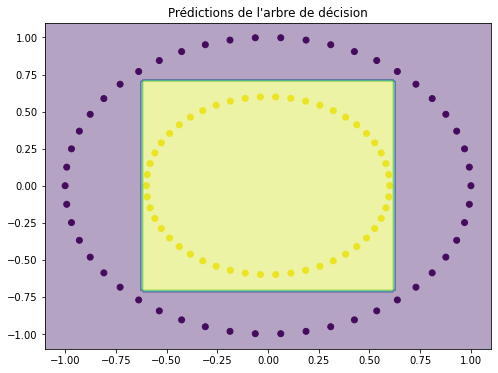

In [27]:
plt.subplots(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y)

grid_1d = np.linspace(-1.1, 1.1, 100)
xx, yy = np.meshgrid(grid_1d, grid_1d)
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)

plt.title("Prédictions de l'arbre de décision")

L'arbre prédit parfaitement la classe, mais sa frontière de décision est un rectangle : C'est parce qu'il ne prend que des décisions binaires sur une seule *feature* à la fois. Visualisons son processus de prédiction :

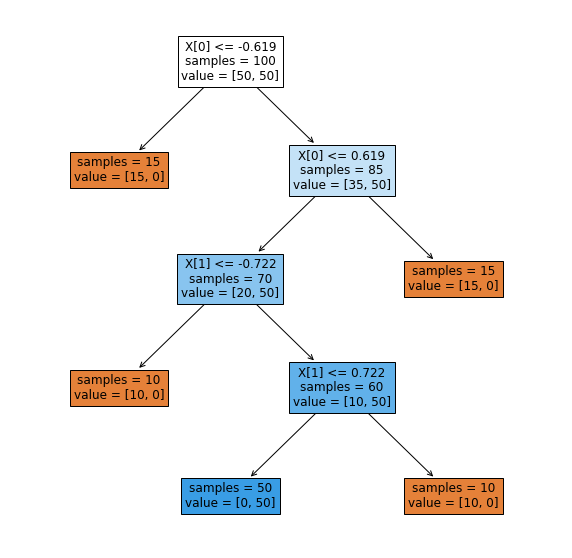

In [36]:
plot_decision_tree(tree)

Comme on peut le voir, l'arbre opère une disjonction de cas sur 5 cas possibles, avec un seul cas (l'intérieur du rectangle) étant de la classe représentée en jaune sur le graphique et les quatre autres étant la classe violette.

#### L'ensemble d'arbres de décision
En mettant ensemble de nombreux arbres de décision, entraînés sur des sous-ensembles des données et des features aléatoires, on peut souvent arriver à de bien meilleures classifications. Ces modèles sont rapides à entraîner, interprétables, et très efficaces sans beaucoup de manipulation d'hyperparamètres, ce qui a fait leur popularité.

L'exemple ci-dessous montre la capacité de ces modèles à apprendre des frontières de décision complexes.

Text(0.5, 1.0, 'Prédictions du modèle RandomForest')

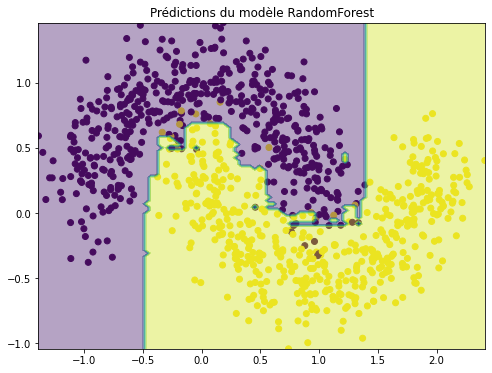

In [139]:
X, y = make_moons(n_samples=1000, noise=0.2)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

plt.subplots(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y)

grid_1d = np.linspace(-1.1, 1.1, 100)
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
Z = rf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)

plt.title("Prédictions du modèle RandomForest")

Ici, nous allons entraîner un classifieur RandomForest sur un jeu de données synthétique, et l'utiliser comme exemple pour illustrer nos optimisations.

In [61]:
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=True)
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

### La version matricielle : l'algorithme GEMM
Pour expliquer la version matricielle de cet algorithme, prenons pour exemple le premier arbre de la RandomForest que nous venons d'entraîner :

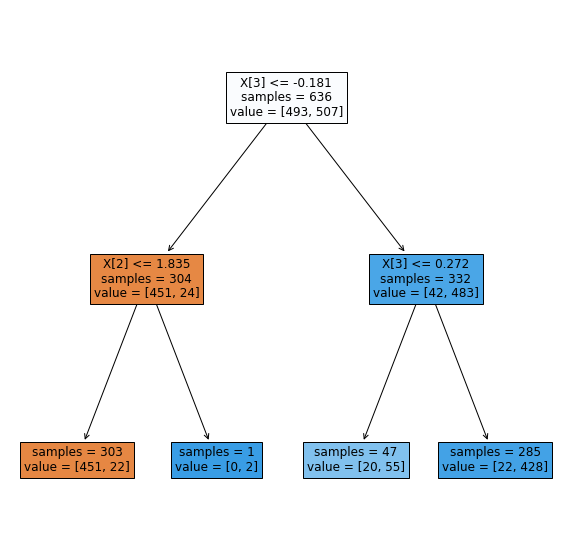

In [62]:
tree = clf.estimators_[0]
plot_decision_tree(tree)

Nous allons invoquer notre fonction de conversion et expliquer ses composantes.

In [63]:
gemm_tree = DecisionTreeGEMM(tree)

In [74]:
for mat in "ABCDE":
    print(f"Matrice {mat} :")
    print(gemm_tree.__getattribute__(mat))
    print("")

Matrice A :
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

Matrice B :
[-0.18058992  1.83501905  0.27233107]

Matrice C :
[[ 1.  1. -1. -1.]
 [ 1. -1.  0.  0.]
 [ 0.  0.  1. -1.]]

Matrice D :
[2 1 1 0]

Matrice E :
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]



Le but de l'algorithme est de vectoriser les tests effectués par les noeuds de l'arbre. Ici, l'arbre effectue un total de 3 tests.

L'entrée de l'arbre est un vecteur de features $x$, ici de taille 4.

Voici comme l'algorithme vectorise les tests de comparaison :

1. D'abord, une première matrice $A$ détermine sur quelles features les 3 tests vont porter. Chaque colonne représente un test, donc ici les tests portent dans l'ordre sur les features d'index 3, 2 et 3. On définit $x_1 = xA$ pour obtenir un vecteur de taille 3.
2. La matrice $B$ contient les seuils des trois tests. On compare $x_1$ terme à terme avec $B$ pour obtenir un nouveau vecteur $x_2$ contenant des 0 et des 1 représentant les résultats des tests.
3. La matrice $C$ permet de trouver le chemin parcouru par le sample dans l'arbre. Chaque ligne indique vers quels sous-noeuds un noeud donné pointe en fonction du résultat de son test. On calcule $x_3 = x_2 C$, qui est un vecteur avec autant de coordonnées que de feuilles de l'arbre. Chaque coefficient de ce vecteur indique combien des tests menant à cette feuille ont été réussis par le sample, moins le nombre de ces tests qui ont été échoués.
4. Ensuite, on compare terme à terme $x_4$ avec la matrice $D$, qui indique pour chaque feuille le nombre de réussites moins le nombre d'échecs qu'il faut pour l'atteindre. On peut vérifier qu'une seule de ces égalités sera vraie, ce qui donne un vecteur avec un 1 à la feuille dans laquelle atterrit le sample, et des 0 ailleurs.
5. Enfin, on multiplie $x_4$ par la matrice $E$, qui indique la classe majoritaire dans les 4 feuilles, et on obtient un vecteur à deux composantes, dont l'une vaut 1 et indique la classe majoritaire de cette feuille (la prédiction de l'arbre), et l'autre vaut 0.

La cellule ci-dessous montre la succession de calculs pour un exemple qui atterrit dans la feuille de gauche.

In [77]:
x = np.array([0, 0, 0, -1])

x_1 = x@gemm_tree.A
x_2 = (x_1 < gemm_tree.B).astype("float")
x_3 = x_2 @ gemm_tree.C
x_4 = (x_3 == gemm_tree.D).astype("float")
x_5 = x_4 @ gemm_tree.E
x_5

array([1., 0.])

In [79]:
# La feuille atteinte est bien celle de gauche
x_4

array([1., 0., 0., 0.])

## Implémentation Naïve
Une fois cette représentation définie, on peut implémenter une RandomForest naïve en définissant une liste d'arbres de décisions mis sous forme matricielles, calculer leurs prédictions indépendamment, puis les aggréger pour produire une prédiction finale. Mesurons l'impact de ce choix sur la performance de l'algorithme.

Nous avons implémenté cet algorithme sous trois backends : numpy, pytorch sur CPU, et pytorch sur GPU. Nous allons mesurer la vitesse des trois.

In [98]:
naive_models = get_all_backends(NaiveRandomForestGEMM, clf)
naive_models

{'numpy': <random_forest_pytorch.random_forest_gemm.NaiveRandomForestGEMM at 0x7fcc96cfbe80>,
 'torch_cpu': <random_forest_pytorch.random_forest_gemm.NaiveRandomForestGEMM at 0x7fcc96cfbd00>,
 'torch_cuda': <random_forest_pytorch.random_forest_gemm.NaiveRandomForestGEMM at 0x7fcc96cf8d30>}

In [123]:
pretty_print_time_all_backends(naive_models, X, number=1000, repeat=7)

numpy      -> 5.14 ms ± 229 µs
torch_cpu  -> 8.86 ms ± 611 µs
torch_cuda -> 10.3 ms ± 217 µs


In [116]:
# Comparons à l'implémentation de sklearn
%timeit -n 1000 -r 7 clf.predict(X)

12.8 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Malgré cette implémentation naïve, nous arrivons en utilisant `numpy` à diviser par 2.5 le temps d'exécution, ce qui est déjà considérable.

## Implémentation optimisée
Cependant, le but de passer à une représentation matricielle, particulièrement si celle-ci est utilisée sur carte graphique, est d'exploiter la capacité du matériel à optimiser les opérations matricielles. Ainsi, plutôt que d'en opérer 100 (le nombre d'arbres) indépendamment puis de concaténer les résultats, ce qui démultiplie les overheads, on devrait pouvoir concaténer les matrices à l'avance pour n'opérer que quelques grosses opérations matricielles. 

C'est ce que nous faisons dans notre implémentation optimisée, ici aussi existant sur les trois backends. Mesurons sa performance.

In [125]:
models = get_all_backends(RandomForestGEMM, clf)
pretty_print_time_all_backends(models, X, number=1000, repeat=7)

numpy      -> 7.59 ms ± 524 µs
torch_cpu  -> 1.67 ms ± 402 µs
torch_cuda -> 387 µs ± 12.1 µs


Comparons enfin à l'implémentation de Hummingbird.

In [118]:
X_pt = torch.tensor(X)
X_pt_cuda = X_pt.cuda()
rf_hb = convert(clf, "pytorch")
rf_hb_cuda = convert(clf, "pytorch").to("cuda")

In [126]:
# A comparer avec le backend torch_cpu
%timeit -n 1000 -r 7 rf_hb.predict(X_pt)

989 µs ± 128 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [127]:
# A comparer avec le backend torch_cuda
%timeit -n 1000 -r 7 rf_hb_cuda.predict(X_pt_cuda)

387 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
